In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import ranksums

In [2]:
task1_df = pd.read_csv("../data/task1_preprocessed.csv")
task2_df = pd.read_csv("../data/task2_preprocessed.csv")

os.makedirs("figures", exist_ok=True)

In [3]:
task1_ai_group = task1_df[task1_df['ai'] == True]
task1_manual_group = task1_df[task1_df['ai'] == False]
task2_treatment = task2_df[task2_df['treatment'] == 'ai']
task2_control = task2_df[task2_df['treatment'] == 'human']

In [4]:
# Define color scheme
colors = {
    'ai_dark_gray': '#4F4F4F',
    'manual_work': 'yellow',
    'treatment_blue': '#1f77b4',  # Blue for treatment
    'control_orange': '#ff7f0e'  # Orange for control
}

# Completion Time

# Task 1

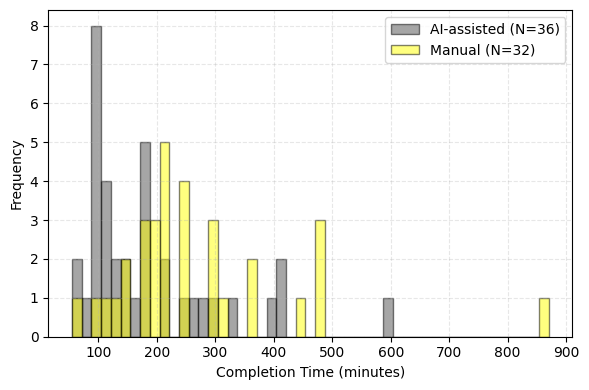

In [5]:
plt.figure(figsize=(6, 4))

# Convert from seconds to minutes
ai_minutes = task1_ai_group['clean_time'].dropna() / 60
manual_minutes = task1_manual_group['clean_time'].dropna() / 60

# Legend labels with sample sizes
ai_label = f"AI-assisted (N={len(ai_minutes)})"
manual_label = f"Manual (N={len(manual_minutes)})"

# Determine combined min/max for consistent binning
combined_min = min(ai_minutes.min(), manual_minutes.min())
combined_max = max(ai_minutes.max(), manual_minutes.max())
bins = np.linspace(combined_min, combined_max, 50)

# Plot histograms
plt.hist(ai_minutes, bins=bins, 
         color=colors['ai_dark_gray'], alpha=0.5, edgecolor='black', label=ai_label)
plt.hist(manual_minutes, bins=bins, 
         color=colors['manual_work'], alpha=0.5, edgecolor='black', label=manual_label)

# Labels and style
plt.xlabel('Completion Time (minutes)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()

# Save to file
plt.savefig("figures/task1_time_distribution.png", dpi=300)

# Show plot
plt.show()

# Task 2

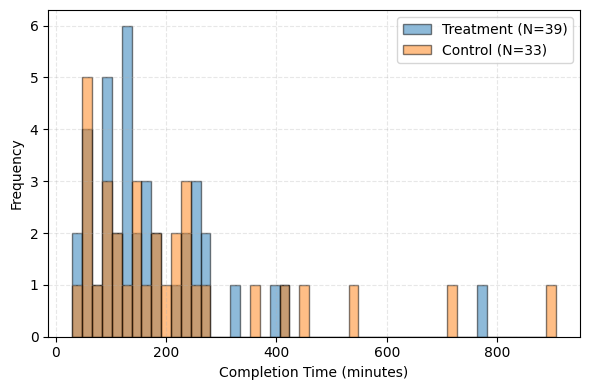

In [6]:
plt.figure(figsize=(6, 4))

# Convert from seconds to minutes using local variables
treatment_minutes = task2_treatment['clean_time'].dropna() / 60
control_minutes = task2_control['clean_time'].dropna() / 60

# Legend labels with sample sizes
treatment_label = f"Treatment (N={len(treatment_minutes)})"
control_label = f"Control (N={len(control_minutes)})"

# Determine combined min/max for consistent binning
combined_min = min(treatment_minutes.min(), control_minutes.min())
combined_max = max(treatment_minutes.max(), control_minutes.max())
bins = np.linspace(combined_min, combined_max, 50)  # 50 equal-width bins

# Plot histograms
plt.hist(treatment_minutes, bins=bins, 
         color=colors['treatment_blue'], alpha=0.5, edgecolor='black', label=treatment_label)
plt.hist(control_minutes, bins=bins, 
         color=colors['control_orange'], alpha=0.5, edgecolor='black', label=control_label)

# Labels and style
plt.xlabel('Completion Time (minutes)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()

# Save to file
plt.savefig("figures/task2_time_distribution.png", dpi=300)

# Show plot
plt.show()

## Inferential statistics

In [7]:
# Extract clean_time values in seconds
treatment_seconds = task2_treatment['clean_time'].dropna()
control_seconds = task2_control['clean_time'].dropna()

# Shapiro–Wilk normality test
stat_treat, p_treat = shapiro(treatment_seconds)
stat_control, p_control = shapiro(control_seconds)

print("Shapiro–Wilk Test for Normality (in seconds):")
print(f"  Treatment: W = {stat_treat:.4f}, p = {p_treat:.4e}")
print(f"  Control:   W = {stat_control:.4f}, p = {p_control:.4e}")

Shapiro–Wilk Test for Normality (in seconds):
  Treatment: W = 0.7718, p = 2.3142e-06
  Control:   W = 0.7787, p = 1.2986e-05


We reject the hypothesis that the data is normally distributed.

In [8]:
# Wilcoxon Rank-Sum Test (Mann–Whitney U) on raw seconds
statistic, p_value = ranksums(treatment_seconds, control_seconds)

print("Wilcoxon Rank-Sum Test (Completion Time in seconds):")
print(f"  Statistic = {statistic:.4f}")
print(f"  p-value   = {p_value:.4e}")

Wilcoxon Rank-Sum Test (Completion Time in seconds):
  Statistic = -0.5764
  p-value   = 5.6436e-01


We cannot reject the null hypothesis that there is no difference.

In [9]:
# Step 3: Calculate Cliff’s Delta effect size
def cliffs_delta(x, y):
    n_x = len(x)
    n_y = len(y)
    greater = 0
    lesser = 0

    # Pairwise comparisons
    for i in x:
        for j in y:
            if i > j:
                greater += 1
            elif i < j:
                lesser += 1

    # Calculate Cliff’s Delta
    delta = (greater - lesser) / (n_x * n_y)
    return delta

In [10]:
# Corrected version - Just pass the Series directly
delta = cliffs_delta(treatment_seconds, control_seconds)
print(f"Cliff’s Delta: δ={delta:.4f}")

# Interpret Cliff’s Delta based on thresholds
if abs(delta) < 0.147:
    magnitude = "negligible"
elif abs(delta) < 0.33:
    magnitude = "small"
elif abs(delta) < 0.474:
    magnitude = "medium"
else:
    magnitude = "large"

print(f"Effect Size Interpretation: {magnitude}")

Cliff’s Delta: δ=-0.0793
Effect Size Interpretation: negligible


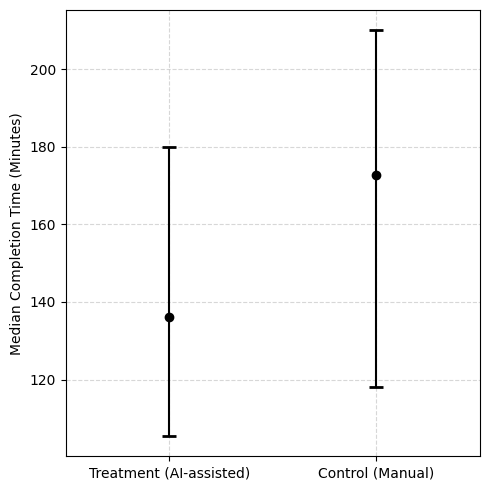

Bootstrap Confidence Intervals (95% CI) for Task 2 (Median) [Minutes]:
Treatment (AI-assisted): 136.1 min  (95% CI: 105.5 - 180.0 min)
Control (Manual):       172.6 min  (95% CI: 118.1 - 210.0 min)


In [11]:
def bootstrap_ci_median(data, n_bootstraps=1000000, ci=95):
    """Compute percentile bootstrap confidence interval for the median"""
    boot_medians = [np.median(np.random.choice(data, size=len(data), replace=True)) for _ in range(n_bootstraps)]
    lower = np.percentile(boot_medians, (100 - ci) / 2)
    upper = np.percentile(boot_medians, 100 - (100 - ci) / 2)
    return np.median(data), lower, upper

# Compute medians and bootstrap CIs (still in seconds)
treatment_median, treatment_lower, treatment_upper = bootstrap_ci_median(treatment_seconds)
control_median, control_lower, control_upper = bootstrap_ci_median(control_seconds)

# Convert to minutes
treatment_median /= 60
treatment_lower /= 60
treatment_upper /= 60
control_median /= 60
control_lower /= 60
control_upper /= 60

# Error bars
lower_bounds = [treatment_median - treatment_lower, control_median - control_lower]
upper_bounds = [treatment_upper - treatment_median, control_upper - control_median]
yerr = [lower_bounds, upper_bounds]

# Plot
plt.figure(figsize=(5, 5))
x_pos = [0, 1]
medians = [treatment_median, control_median]

plt.errorbar(x_pos, medians, yerr=yerr, fmt='o', capsize=5, capthick=2, color='black')

# Fix x-axis labels and spacing
plt.xticks(x_pos, ['Treatment (AI-assisted)', 'Control (Manual)'])
plt.xlim(-0.5, 1.5)  # This removes excess horizontal space
plt.ylabel('Median Completion Time (Minutes)')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("figures/task2_bootstrap_median_ci.png", dpi=300)
plt.show()

# Print summary
print("Bootstrap Confidence Intervals (95% CI) for Task 2 (Median) [Minutes]:")
print(f"Treatment (AI-assisted): {treatment_median:.1f} min  (95% CI: {treatment_lower:.1f} - {treatment_upper:.1f} min)")
print(f"Control (Manual):       {control_median:.1f} min  (95% CI: {control_lower:.1f} - {control_upper:.1f} min)")


# Bonus! Comparing AI-dev and !AI-dev for Task 1

In [12]:
# Extract clean_time values in seconds for Task 1
ai_seconds = task1_ai_group['clean_time'].dropna()
manual_seconds = task1_manual_group['clean_time'].dropna()

# Shapiro–Wilk normality test
stat_ai, p_ai = shapiro(ai_seconds)
stat_manual, p_manual = shapiro(manual_seconds)

print("Shapiro–Wilk Test for Normality (Task 1, in seconds):")
print(f"  AI-assisted: W = {stat_ai:.4f}, p = {p_ai:.4e}")
print(f"  Manual:      W = {stat_manual:.4f}, p = {p_manual:.4e}")

Shapiro–Wilk Test for Normality (Task 1, in seconds):
  AI-assisted: W = 0.8292, p = 6.5532e-05
  Manual:      W = 0.8205, p = 1.0128e-04


We reject the null hypothesis that the distributions are normally distributed.

In [13]:
# Wilcoxon Rank-Sum Test (Mann–Whitney U) on raw seconds
statistic, p_value = ranksums(ai_seconds, manual_seconds)

print("Wilcoxon Rank-Sum Test (Completion Time in seconds):")
print(f"  Statistic = {statistic:.4f}")
print(f"  p-value   = {p_value:.4e}")

Wilcoxon Rank-Sum Test (Completion Time in seconds):
  Statistic = -2.9734
  p-value   = 2.9451e-03


We reject the null hypothesis that their is no difference.

In [14]:
# Corrected version - Just pass the Series directly
delta = cliffs_delta(ai_seconds, manual_seconds)
print(f"Cliff’s Delta: δ={delta:.4f}")

# Interpret Cliff’s Delta based on thresholds
if abs(delta) < 0.147:
    magnitude = "negligible"
elif abs(delta) < 0.33:
    magnitude = "small"
elif abs(delta) < 0.474:
    magnitude = "medium"
else:
    magnitude = "large"

print(f"Effect Size Interpretation: {magnitude}")

Cliff’s Delta: δ=-0.4201
Effect Size Interpretation: medium


In [15]:
# Extract clean_time in seconds for Task 1
ai_seconds = task1_ai_group['clean_time'].dropna()
manual_seconds = task1_manual_group['clean_time'].dropna()

# Compute descriptive statistics
ai_stats = ai_seconds.describe().round(2)
manual_stats = manual_seconds.describe().round(2)

# Compute medians
ai_median = ai_stats['50%']
manual_median = manual_stats['50%']

# Compute percentage difference in medians
percent_diff = ((manual_median - ai_median) / manual_median) * 100

# Display results
print("AI-assisted participants (seconds):")
print(ai_stats)

print("\nManual participants (seconds):")
print(manual_stats)

print(f"\nPercentage difference in medians: {percent_diff:.1f}% (reduction from manual to AI)")

AI-assisted participants (seconds):
count       36.00
mean     11159.56
std       7317.56
min       3290.00
25%       5726.75
50%       9120.50
75%      13050.00
max      36000.00
Name: clean_time, dtype: float64

Manual participants (seconds):
count       32.00
mean     16031.78
std       9366.93
min       3600.00
25%      10800.00
50%      13167.50
75%      18300.00
max      52200.00
Name: clean_time, dtype: float64

Percentage difference in medians: 30.7% (reduction from manual to AI)
